In [ ]:
# Google Mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Modeling Seasonal Variations (계절적 변동 모델링)

## $y_t = TR_t + SN_t + \epsilon_t$

- $y_t$: the value of the time series in period $t$
- $TR_t$: the trend in time period $t$
- $SN_t$: the seasonal factor(요인) in time period $t$
- $\epsilon_t$: the error term (irregular factor:불규칙 요인) in time period $t$

## Visualization for Item Sales Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.stats.stattools import durbin_watson

# The data contatins daily sales of 50 items in 10 stores from a period of 5 years (500 different time series in total.)
df = pd.read_csv('/content/drive/Shared drives/timeseries-datasets/Item_Demand.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [ ]:
# For our purpose we need only one time series so I will arbitrarily take sales of Item 1 at Store 1.
df = df[(df['store'] == 1) & (df['item'] == 1)] # item 1 in store 1
df['date'] = pd.to_datetime(df['date'])

df = df.set_index('date')
y = df['sales']

y_to_train = y.iloc[:len(y)-365]
y_to_test = y.iloc[len(y)-365:] # last year for testing

print("the number of train data :" + str(len(y_to_train)))
print("the number of test data :" + str(len(y_to_test)))


the number of train data :1461
the number of test data :365


<ipython-input-3-8009691cd884>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


In [ ]:
# --Other methods to split the data--

# 1. Pandas Head and Tail Feature
y_to_train2 = y.head(len(y)-365)
y_to_test2 = y.tail(365)

# 2. iloc with a specific value
train_size = len(y) - 365
y_to_train3 = y.iloc[:train_size]
y_to_test3 = y.iloc[train_size:]

# 3. .index Attribute
y_to_train4 = y[y.index < y.index[train_size]]
y_to_test4 = y[y.index >= y.index[train_size]]

print("the number of train data :" + str(len(y_to_train2)))
print("the number of test data :" + str(len(y_to_test2)))
print("--------------------------------------------------")
print("the number of train data :" + str(len(y_to_train3)))
print("the number of test data :" + str(len(y_to_test3)))
print("--------------------------------------------------")
print("the number of train data :" + str(len(y_to_train4)))
print("the number of test data :" + str(len(y_to_test4)))
print("--------------------------------------------------")

the number of train data :1461
the number of test data :365
--------------------------------------------------
the number of train data :1461
the number of test data :365
--------------------------------------------------
the number of train data :1461
the number of test data :365
--------------------------------------------------


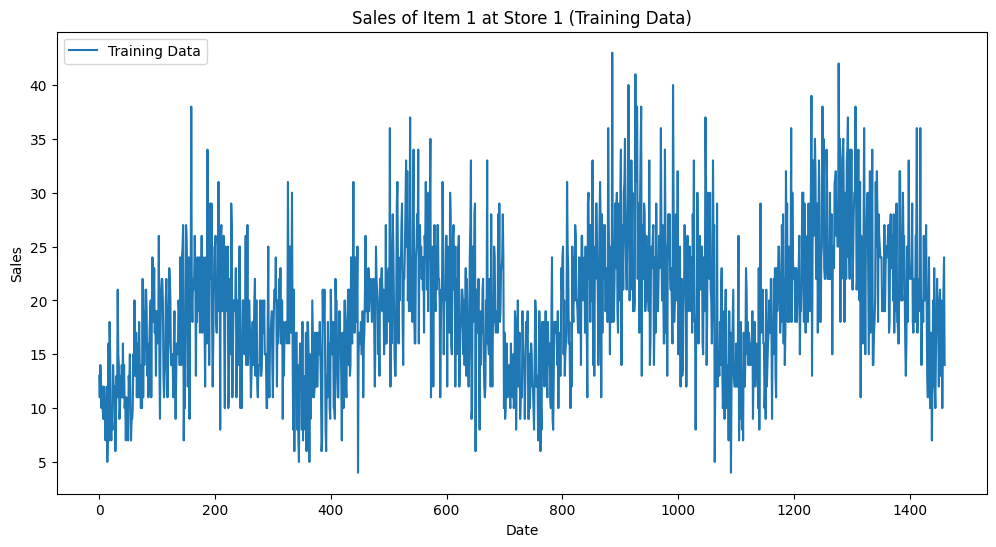

In [ ]:
import matplotlib.pyplot as plt

# y_to_train visualization
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_to_train)), y_to_train.values, label='Training Data')
#plt.plot(df.index[:len(y_to_train)], y_to_train.values, label='Training Data')
plt.title('Sales of Item 1 at Store 1 (Training Data)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

## Trend linear modeling ($TR_t$ Modeling)

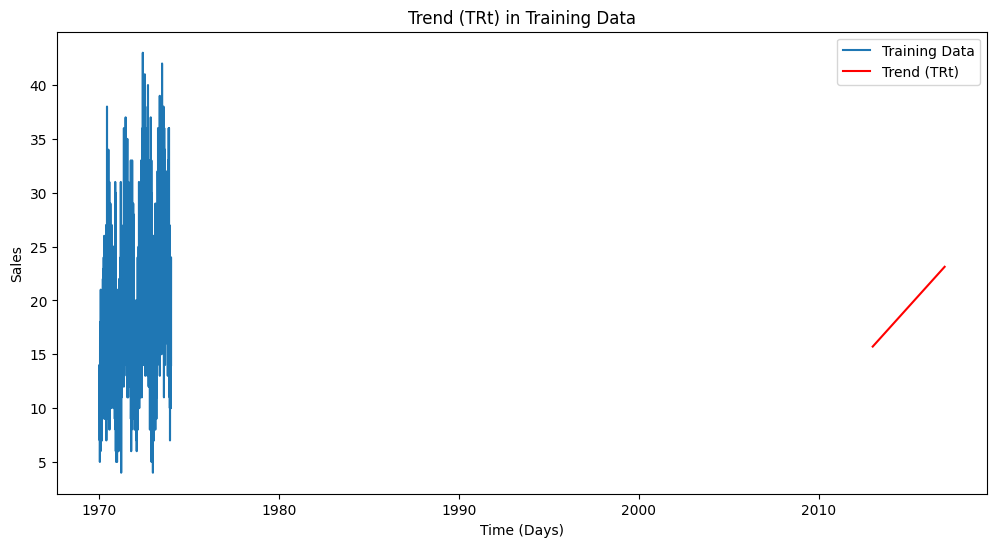

In [ ]:
X_train_trend = np.arange(len(y_to_train)).reshape(-1, 1)
'''
np.arange(len(y_to_train)): 0부터 len(y_to_train)-1까지의 정수 배열을 생성. 즉, 훈련 데이터의 길이만큼의 배열을 만들어서, 각 데이터 포인트의 순서를 나타냄.
.reshape(-1, 1): 이 배열을 열 벡터(2차원 배열)로 변환. 선형 회귀 모델에 입력하기 위해서는 2차원 배열이 필요하므로 이 작업을 수행한다.
X_train_trend : 훈련 데이터의 시간 순서를 나타내는 특징(feature) 역할을 하게 된다.
'''
y_train_trend = y_to_train.values
#판매량 데이터를 추출하여 종속변수(target)로 사용 -> 선형 회귀 모델에서 예측하려는 목표데이터.

trend_model = LinearRegression() #선형회귀 모델 생성
trend_model.fit(X_train_trend, y_train_trend) 
#X_train_trend(시간 순서)와 y_train_trend(판매량)를 기반으로 선형 회귀 모델을 학습시키는 코드. 즉, 시간에 따른 판매량의 추세(Trend)를 학습.

TRt_train = trend_model.predict(X_train_trend)
#학습된 모델을 사용해 훈련 데이터의 시간 순서에 따른 판매량의 추세(Trend)를 예측

# [Question: What will happen if you mix indexing and range numbers in one plot]
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_to_train)), y_to_train.values, label='Training Data') #range(len(y_to_train)을 df.index[:len(y_train_trend)]으로 바꾸면 됨
plt.plot(df.index[:len(y_train_trend)], TRt_train, label='Trend (TRt)', color='red')
plt.title('Trend (TRt) in Training Data')
plt.xlabel('Time (Days)')
plt.ylabel('Sales')
plt.legend()
plt.show()

## Seasonality Modeling - 1-1. $SN_t$ using Binary Variables

$$
y_t = TR_t + SN_t + \epsilon_t
$$
$$
= \beta_0 + \beta_1 t + \beta_2 M_1 + \beta_3 M_2 + \beta_3 M_3 + \cdots + \beta_{12} M_{11} + \epsilon_t
$$

where  $ M_1, M_2, \dots, M_{11} $ are seasonal binary variables.

$$
M_1 =
\begin{cases}
1 & \text{if period t is January} \\
0 & \text{otherwise}
\end{cases}
$$



In [ ]:
y_to_train.head()

,sales
date,
2013-01-01,13
2013-01-02,11
2013-01-03,14
2013-01-04,13
2013-01-05,10


In [ ]:
# Data Preprocessing for modeling
df_train_bi = y_to_train.to_frame() 
#y_to_train을 Pandas DataFrame으로 변환하여 df_train_bi라는 새로운 DataFrame을 생성. (Pandas Series->Pandas DataFrame)
#시간이나 월 을 추가하기 위해 2차원 구조 필요
#Series: 1차원 데이터 구조 (인덱스 - 값) (DataFrame의 한 열에 해당, 1차원 데이터를 처리하거나 분석할 때 유용하게 사용,다양한 인덱스와 데이터 타입을 가질 수 있음)
#이 과정에서 인덱스는 그대로 유지되고, 데이터는 한 열에 들어감.

df_train_bi['t'] = np.arange(1, len(df_train_bi) + 1)
#t 열: 데이터 포인트의 순서를 나타내는 시간 변수를 생성. 1부터 데이터포인트의 개수까지 정수 배열 생성
df_train_bi['constant']=1
#constant 열: 선형 회귀 모델의 상수항을 위한 열을 추가. 모든 값이 1로 설정되어, 이 열은 회귀 모델에서 절편을 계산하는 데 사용됨.
df_train_bi['month'] = df_train_bi.index.month
#month 열: 인덱스에서 월 정보를 추출하여 새로운 열을 생성. 이는 각 데이터 포인트의 날짜에서 월을 가져옴.

# Create month dummy variables
#더미변수 : 범주형 데이터를 수치형 데이터로 변환할 때 사용되는 이진 변수(0 또는 1)
df_train_bi = pd.get_dummies(df_train_bi, columns=['month'], drop_first=False)
#더미 변수: month 열을 기반으로 더미 변수를 생성. drop_first=False: 첫 번째 월을 더미 변수에서 제외하지 않도록 설정하여 모든 월에 대한 더미 변수를 만든다.
'''
범주형 데이터를 수치화: 범주형 변수는 숫자로 표현되지 않기 때문에 모델이 직접적으로 이해하기 어렵습니다. 그래서 각 범주를 0과 1로 변환하는 방식으로 데이터를 표현합니다.

예를 들어, "계절"이라는 변수에 '봄', '여름', '가을', '겨울'이라는 네 가지 범주가 있을 때, 이를 네 개의 더미변수로 변환하면 각각의 계절이 해당할 때만 1, 나머지는 0으로 나타냅니다.

'''

# Remove the December column
df_train_bi.drop(columns=['month_12'], inplace=True)
#inplce= True: 연산 결과가 원본 객체에 직접 반영. 즉, 새로운 객체를 생성하지 않고 기존의 DataFrame 또는 Series에 바로 적용됨.

# Ensure that each month column only has values for the respective month **어렵다 !!! (어쨌든 해당하는 달에만 1로 나타낸단 의미)
month_columns = [col for col in df_train_bi.columns if col.startswith('month_')]
for col in month_columns:
    month = int(col.split('_')[1])
    df_train_bi[col] = (df_train_bi.index.month == month).astype(int)


df_train_bi.head()

#데이터를 분석하고 모델링하는 데 필요한 구조를 마련함!

,sales,t,constant,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11
date,,,,,,,,,,,,,,
2013-01-01,13,1,1,1,0,0,0,0,0,0,0,0,0,0
2013-01-02,11,2,1,1,0,0,0,0,0,0,0,0,0,0
2013-01-03,14,3,1,1,0,0,0,0,0,0,0,0,0,0
2013-01-04,13,4,1,1,0,0,0,0,0,0,0,0,0,0
2013-01-05,10,5,1,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Prepare data for modelling
X_train_seasonal_binary = df_train_bi.drop(columns=['sales'])
y_train_seasonal_binary = df_train_bi['sales']

'''
X_train_seasonal_binary: df_train_bi DataFrame에서 sales 열을 제외한 나머지 모든 열을 포함하는 새로운 DataFrame을 생성. 이 새로운 DataFrame은 모델의 입력으로 사용될 특징 변수(Feature Variables)를 의미함.
y_train_seasonal_binary: df_train_bi DataFrame에서 sales 열만을 선택하여 **타겟 변수(Target Variable)**로 정의. 이 변수는 모델이 예측해야 하는 값임!

'''

print("X_train_seasonal_binary :")
print(X_train_seasonal_binary)
print("y_train_seasonal_binary :")
print(y_train_seasonal_binary)


X_train_seasonal_binary :
               t  constant  month_1  month_2  month_3  month_4  month_5  \
date                                                                      
2013-01-01     1         1        1        0        0        0        0   
2013-01-02     2         1        1        0        0        0        0   
2013-01-03     3         1        1        0        0        0        0   
2013-01-04     4         1        1        0        0        0        0   
2013-01-05     5         1        1        0        0        0        0   
...          ...       ...      ...      ...      ...      ...      ...   
2016-12-27  1457         1        0        0        0        0        0   
2016-12-28  1458         1        0        0        0        0        0   
2016-12-29  1459         1        0        0        0        0        0   
2016-12-30  1460         1        0        0        0        0        0   
2016-12-31  1461         1        0        0        0        0        0   

Intercept: 9.861580268145346
Coefficients:
t: 0.004762480095848769
constant: -8.881784197001252e-16
month_1: 0.6805686494567567
month_2: 1.2374857269290014
month_3: 4.648391703777722
month_4: 7.3689962759080805
month_5: 8.454654611479338
month_6: 10.695151656728013
month_7: 12.010917519180964
month_8: 8.201990313629008
month_9: 6.8986701545766
month_10: 5.387285479395156
month_11: 7.149825535396506


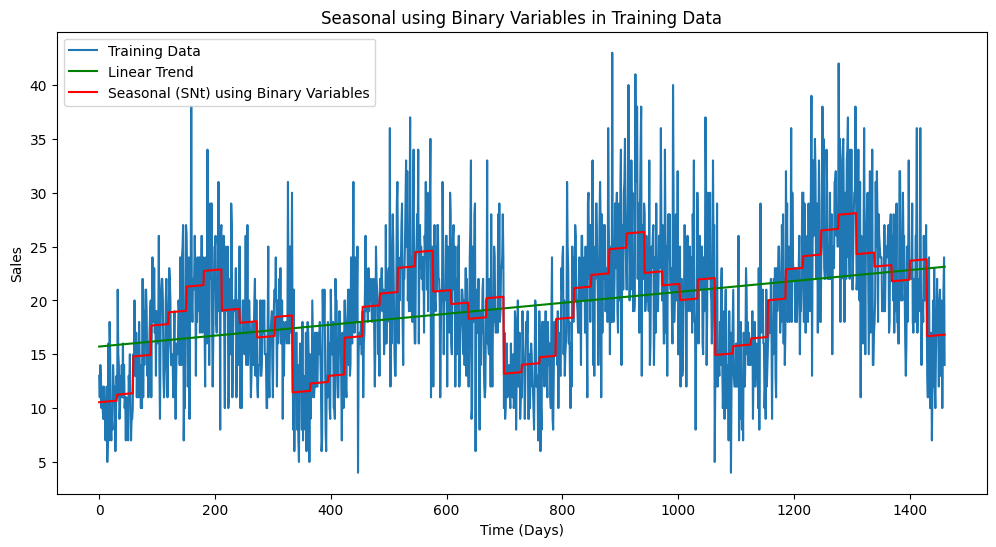

In [ ]:
# Train a linear regression model
seasonal_model_binary = LinearRegression()
seasonal_model_binary.fit(X_train_seasonal_binary, y_train_seasonal_binary)
SNt_train_binary = seasonal_model_binary.predict(X_train_seasonal_binary)

# Output regression coefficients
coefficients = seasonal_model_binary.coef_
intercept = seasonal_model_binary.intercept_

print("Intercept:", intercept)
print("Coefficients:")
for col, coef in zip(X_train_seasonal_binary.columns, coefficients):
    print(f"{col}: {coef}")


'''
절편은 종속 변수(y)가 독립 변수(X)의 값에 관계없이 얼마인지를 나타냅니다.
회귀 계수는 각 독립 변수(X)가 종속 변수(y)에 미치는 영향을 나타냅니다.
결론적으로, 회귀 계수는 각 특징 변수의 값 변화에 따른 종속 변수의 변화량을, 절편은 독립 변수가 없는 상황에서의 종속 변수 값을 의미합니다.

1. 회귀 계수 (coef_):
회귀 계수는 각 **특징 변수(feature)**가 **종속 변수(y)**에 미치는 영향을 나타냅니다.
각 특징 변수는 독립 변수라고도 하며, 모델의 입력값에 해당합니다. 예를 들어, 시간, 날씨, 마케팅 비용 등이 있을 수 있습니다.
양수의 회귀 계수는 해당 변수의 값이 증가할 때 종속 변수(예: 판매량)도 증가한다는 의미입니다.
음수의 회귀 계수는 해당 변수의 값이 증가할 때 종속 변수(예: 판매량)가 감소한다는 것을 의미합니다.
예를 들어, 만약 '광고비'라는 특징 변수의 회귀 계수가 2라면, 광고비가 1단위 증가할 때 판매량이 평균적으로 2단위 증가한다는 의미입니다.

2. 절편 (intercept_):
절편은 모든 독립 변수가 0일 때 종속 변수의 예측값, 즉 기본값을 나타냅니다.
절편은 회귀 직선이 y축과 만나는 지점을 의미합니다.
예를 들어, 독립 변수가 없는 상태(모든 입력값이 0일 때)에 모델이 예측하는 기본적인 판매량이 얼마인지를 나타냅니다.
예시:
회귀 계수: 광고비 변수의 계수가 3이면 광고비가 1만큼 증가할 때마다 판매량이 3만큼 증가한다는 의미입니다.
절편: 모든 입력값이 0일 때 (즉, 광고비도 0일 때) 모델이 예측하는 판매량이 50이라면 절편 값은 50입니다.

'''



# Visualization
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_to_train)), y_to_train.values, label='Training Data')
plt.plot(range(len(y_to_train)), TRt_train, label='Linear Trend', color='green')
plt.plot(range(len(y_to_train)), SNt_train_binary, label='Seasonal (SNt) using Binary Variables', color='red')
plt.title('Seasonal using Binary Variables in Training Data')
plt.xlabel('Time (Days)')
plt.ylabel('Sales')
plt.legend()
plt.show()

## Seasonality Modeling - 1.2. $SN_t$ using Trigonometric Variables

$$
y_t = \beta_0 + \beta_1 t + \beta_2 \sin\left(\frac{2\pi t}{L}\right) + \beta_3 \cos\left(\frac{2\pi t}{L}\right)
+ \beta_4 \sin\left(\frac{4\pi t}{L}\right) + \beta_5 \cos\left(\frac{4\pi t}{L}\right) + \epsilon_t
$$

In [ ]:
# Data Preprocessing for modeling
df_train_tri = y_to_train.to_frame()

df_train_tri['t'] = np.arange(1, len(df_train_tri) + 1)
df_train_tri['constant']=1

# L represents the period
# L = 30 means the cycle is 30 days, which assumes the data follows a monthly pattern
# L은 주기를 나타냄. L = 30은 이 데이터가 30일 주기를 가지는 월별 패턴을 따른다고 가정. 즉, 매달의 패턴을 모형화하려는 시도이다 !
L = 30
df_train_tri['(sin2pi)/L'] = np.sin(2 * np.pi * df_train_tri['t'] / L)
df_train_tri['(cos2pi)/L'] = np.cos(2 * np.pi * df_train_tri['t'] / L)
df_train_tri['(sin4pi)/L'] = np.sin(4 * np.pi * df_train_tri['t'] / L)
df_train_tri['(cos4pi)/L'] = np.cos(4 * np.pi * df_train_tri['t'] / L)

'''

주기성 모델링은 데이터가 주기적으로 변하는 패턴을 수학적인 함수(보통 사인(sin) 또는 코사인(cos) 함수)로 나타내어 모델이 데이터를 더 잘 설명하고 예측하도록 돕는 것입니다.
삼각 함수(사인, 코사인)는 주기적인 패턴을 수학적으로 표현하는 데 탁월합니다. 그 이유는 삼각 함수가 **파동(wave)**의 형태를 가지며, 주기가 있습니다.

예를 들어, 데이터가 월별 주기를 갖는다고 가정하면, 이를 사인 및 코사인 함수를 사용하여 모델링할 수 있습니다:

	•	**np.sin(2 * np.pi * t / L)**와 np.cos(2 * np.pi * t / L): 여기서 L은 데이터의 주기입니다. 
 이 경우 L = 30으로 설정하여 데이터가 30일 주기를 따른다고 가정합니다.
	•	t는 시간 변수로, 시간이 변할수록 t 값도 변하면서 삼각 함수의 값도 변동합니다.
	•	삼각 함수는 반복되는 패턴을 가지기 때문에 주기성을 잘 모델링할 수 있습니다.

왜 이렇게 하는가?

삼각 함수의 형태는 데이터가 주기적으로 증가하고 감소하는 패턴을 잘 표현합니다. 예를 들어, 30일 주기로 변동하는 데이터를 모델링할 때:

	•	sin 함수는 데이터의 변동이 아래에서 위로 움직이는 패턴을 표현합니다.
	•	cos 함수는 데이터의 변동이 위에서 아래로 움직이는 패턴을 표현합니다.

결과적으로, 사인과 코사인 함수를 사용하면 시간에 따라 규칙적으로 변동하는 패턴을 설명할 수 있습니다. 
이렇게 하면 모델이 단순한 선형 증가나 감소를 넘어, 주기적으로 반복되는 변동을 더 잘 예측할 수 있게 됩니다.

'''


In [ ]:
# Prepare data for modelling
X_train_seasonal_tri = df_train_tri.drop(columns=['sales'])
y_train_seasonal_tri = df_train_tri['sales']


print("X_train_seasonal_tri :")
print(X_train_seasonal_tri)
print("y_train_seasonal_tri :")
print(y_train_seasonal_tri)


X_train_seasonal_tri :
               t  constant  (sin2pi)/L  (cos2pi)/L  (sin4pi)/L  (cos4pi)/L
date                                                                      
2013-01-01     1         1    0.207912    0.978148    0.406737    0.913545
2013-01-02     2         1    0.406737    0.913545    0.743145    0.669131
2013-01-03     3         1    0.587785    0.809017    0.951057    0.309017
2013-01-04     4         1    0.743145    0.669131    0.994522   -0.104528
2013-01-05     5         1    0.866025    0.500000    0.866025   -0.500000
...          ...       ...         ...         ...         ...         ...
2016-12-27  1457         1   -0.406737   -0.913545    0.743145    0.669131
2016-12-28  1458         1   -0.587785   -0.809017    0.951057    0.309017
2016-12-29  1459         1   -0.743145   -0.669131    0.994522   -0.104528
2016-12-30  1460         1   -0.866025   -0.500000    0.866025   -0.500000
2016-12-31  1461         1   -0.951057   -0.309017    0.587785   -0.809017

[

Intercept: 15.708409496139216
Coefficients:
t: 0.005075813548526889
constant: -1.3877787807814457e-17
(sin2pi)/L: 0.03985040901929752
(cos2pi)/L: 0.10667765595437807
(sin4pi)/L: 0.09757202490850651
(cos4pi)/L: -0.06291419020926556


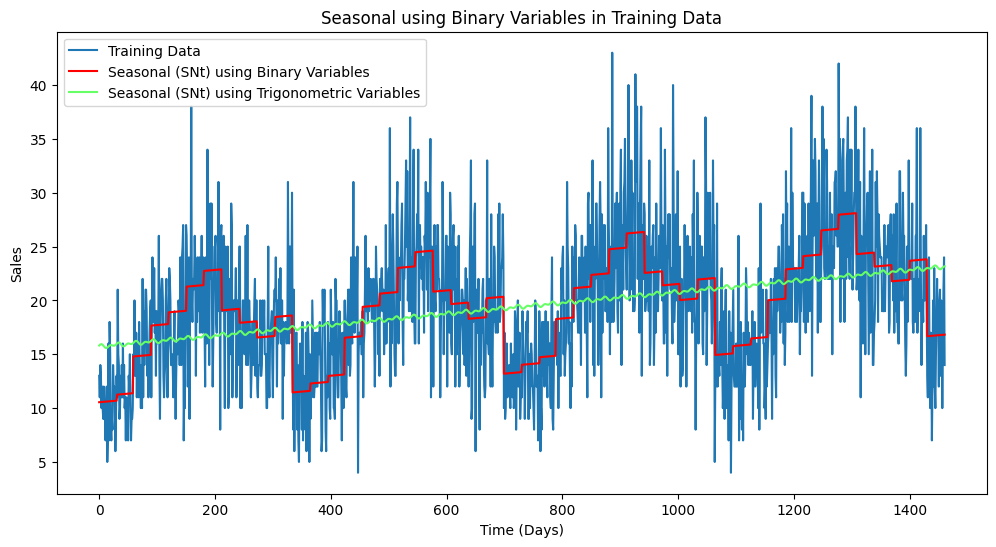

In [ ]:
# Train regression model
seasonal_model_tri = LinearRegression()
seasonal_model_tri.fit(X_train_seasonal_tri, y_train_seasonal_tri)
STT_train_binary = seasonal_model_tri.predict(X_train_seasonal_tri)

# Output regression coefficients
tri_coefficients = seasonal_model_tri.coef_
tri_intercept = seasonal_model_tri.intercept_

print("Intercept:", tri_intercept)
print("Coefficients:")
for col, coef in zip(X_train_seasonal_tri.columns, tri_coefficients):
    print(f"{col}: {coef}")



# visualization
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_to_train)), y_to_train.values, label='Training Data')
#plt.plot(range(len(y_to_train)), TRt_train, label='Linear Trend', color='brown')
plt.plot(range(len(y_to_train)), SNt_train_binary, label='Seasonal (SNt) using Binary Variables', color='red')
plt.plot(range(len(y_to_train)), STT_train_binary, label='Seasonal (SNt) using Trigonometric Variables', color=(0.4, 1.0, 0.4))
plt.title('Seasonal using Binary Variables in Training Data')
plt.xlabel('Time (Days)')
plt.ylabel('Sales')
plt.legend()
plt.show()


### **Binary Variables** are used when seasonality is simple and clearly defined at specific points in time (e.g., monthly sales). They are easy to interpret but can lead to an increase in the number of variables. On the other hand, **Trigonometric Variables** are useful when the seasonal pattern is smooth and continuous (e.g., temperature changes). They can capture complex cycles with fewer variables, but the interpretation may not be as intuitive.

이진 변수(Binary Variables)는 계절성이 특정 시점(예: 월별 판매량)에서 단순하고 명확하게 정의되는 경우에 사용됩니다. 해석이 쉽지만 변수의 개수가 늘어날 수 있다는 단점이 있습니다.

반면에, 삼각 함수 변수(Trigonometric Variables)는 계절 패턴이 부드럽고 연속적일 때(예: 온도 변화) 유용합니다. 이러한 변수는 적은 수의 변수로 복잡한 주기를 포착할 수 있지만, 그 해석이 직관적이지 않을 수 있습니다.


## Durbin-Watson Test for autocorrelation check for residuals

**Durbin-Watson Test** is a statistic used in regression analysis to detect the presence of autocorrelation (a relationship between sequential residuals) in the residuals of a model. The test returns a value between 0 and 4, where a value close to 2 indicates no autocorrelation. A value less than 2 suggests positive autocorrelation, and a value greater than 2 suggests negative autocorrelation.

더빈-왓슨(Durbin-Watson) 테스트는 회귀분석에서 **잔차의 자기상관(autocorrelation)**이 존재하는지 확인하기 위해 사용되는 통계량입니다. 잔차는 모델의 예측값과 실제값 간의 차이를 의미하며, 자기상관은 연속적인 잔차들 간에 관계가 있는지를 나타냅니다.

테스트 결과는 0에서 4 사이의 값을 반환하며:

	•	2에 가까운 값은 자기상관이 없음을 의미합니다.
	•	2보다 작은 값은 양의 자기상관을 나타내며, 이는 잔차들이 연속적으로 비슷한 패턴을 보인다는 것을 의미합니다.
	•	2보다 큰 값은 음의 자기상관을 나타내며, 이는 잔차들이 교대로 나타나는 패턴을 보인다는 것을 의미합니다.

따라서 더빈-왓슨 값이 2에 가까울수록 잔차 간의 관계가 없고, 2에서 멀어질수록 자기상관이 존재한다고 해석할 수 있습니다.

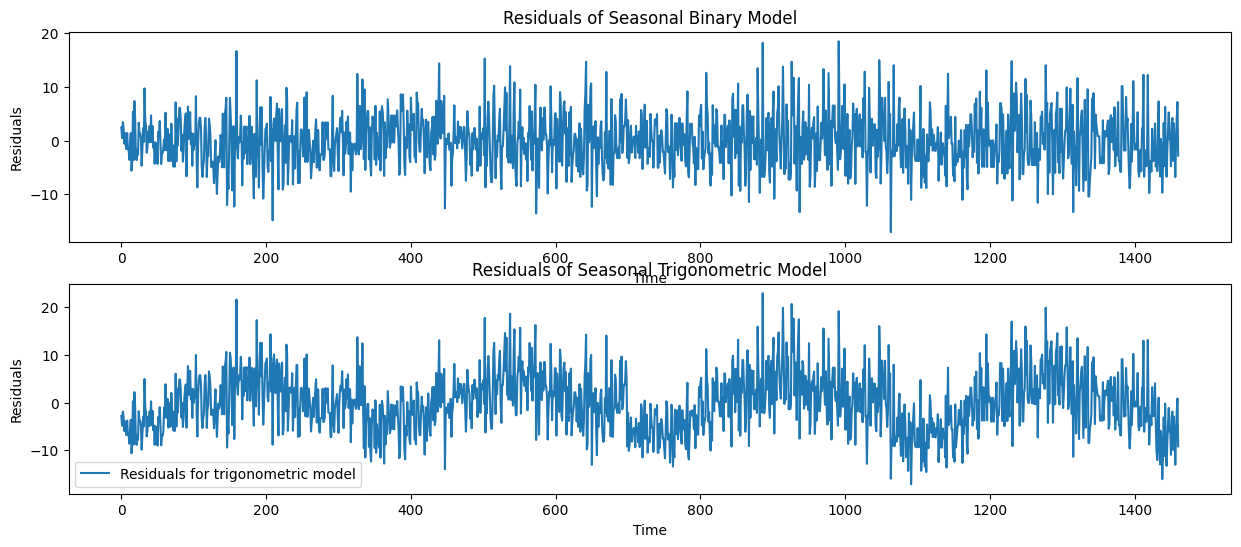

Durbin-Watson Test Statistic (Binary Variables): 1.8951545459125434
Durbin-Watson Test Statistic (Trigonometric): 1.2383844962225397


In [ ]:
'''이 코드는 두 개의 시계열 모델(이진 변수 모델과 삼각 함수 모델)에서 **잔차(residuals)**를 계산하고, 
그 잔차에 대해 더빈-왓슨 테스트를 수행하여 **자기상관(autocorrelation)**을 확인하는 과정입니다.
'''

seasonal_binary_residual = np.ravel((y_to_train.values - SNt_train_binary))
seasonal_tri_residual = np.ravel((y_to_train.values - STT_train_binary))

'''잔차는 실제 값과 모델이 예측한 값의 차이를 의미합니다. 이 코드에서는 y_to_train.values가 실제 값이고, SNt_train_binary와 STT_train_binary는 각각 이진 변수 모델과 삼각 함수 모델의 예측값입니다.
	•	seasonal_binary_residual과 seasonal_tri_residual은 이 두 모델의 잔차를 계산한 것입니다.
	•	np.ravel은 데이터의 차원을 1차원으로 변환합니다.
 '''

# Calculate Durbin-Watson test statistic
dw_binary_test = durbin_watson(seasonal_binary_residual)
dw_tri_test = durbin_watson(seasonal_tri_residual)

'''
durbin_watson() 함수는 잔차의 자기상관을 확인하는 더빈-왓슨 테스트를 수행.
dw_binary_test와 dw_tri_test는 각각 이진 변수 모델과 삼각 함수 모델의 더빈-왓슨 통계값을 반환. 
이 값은 0에서 4 사이의 값을 가지며, 2에 가까우면 잔차의 자기상관이 없음을 의미함.

'''

plt.figure(figsize=(15, 6))
plt.subplot(2,1,1)
plt.plot(seasonal_binary_residual, label='Residuals for binary variable model')
plt.title('Residuals of Seasonal Binary Model')
plt.xlabel('Time')
plt.ylabel('Residuals')

plt.subplot(2,1,2)
plt.plot(seasonal_tri_residual, label='Residuals for trigonometric model')

plt.title('Residuals of Seasonal Trigonometric Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()


print(f'Durbin-Watson Test Statistic (Binary Variables): {dw_binary_test}')
print(f'Durbin-Watson Test Statistic (Trigonometric): {dw_tri_test}')


Test Result Interpretation:
The **binary variable model** has a Durbin-Watson statistic of 1.895, which is very close to 2, indicating little to no autocorrelation in the residuals. This suggests that the model explains the data well. On the other hand, the **trigonometric model** has a value of 1.238, indicating the presence of positive autocorrelation. This implies that the trigonometric model may not explain the seasonality in the data as effectively as the binary variable model.

테스트 결과 해석: 이진 변수 모델은 더빈-왓슨 통계량이 1.895로, 2에 매우 가까운 값을 가집니다. 이는 잔차에 자기상관이 거의 없음을 나타내며, 모델이 데이터를 잘 설명하고 있다는 것을 의미합니다. 반면에 삼각 함수 모델은 1.238의 값을 가지며, 이는 양의 자기상관이 존재함을 나타냅니다. 이는 삼각 함수 모델이 이진 변수 모델만큼 데이터의 계절성을 효과적으로 설명하지 못할 수 있음을 암시합니다.



1.	잔차는 모델의 오차: 잔차(residuals)는 모델이 예측한 값과 실제 값의 차이입니다. 즉, 모델이 설명하지 못한 부분을 나타냅니다.
2.	랜덤하게 분포되어야 이상적인 잔차: 모델이 데이터를 잘 설명한다면 잔차는 랜덤하게 분포되어야 합니다. 이는 모델이 데이터의 패턴을 거의 모두 잘 설명했고, 잔차에 어떤 체계적인 패턴이 남지 않았다는 의미입니다.
3.	자기상관의 의미: 자기상관(autocorrelation)이 있다는 것은 잔차들이 시간에 따라 어떤 연관성을 가진다는 뜻입니다. 즉, 한 시점의 잔차가 다음 시점의 잔차에 영향을 미치는 경우입니다. 이러한 패턴이 있다는 것은 모델이 데이터의 일부 패턴을 충분히 설명하지 못했다는 신호일 수 있습니다.
4.	자기상관이 없는 경우: 잔차에 자기상관이 없으면 각 시점의 잔차가 다른 시점의 잔차와 연관되지 않고, 무작위적으로 나타납니다. 이는 모델이 데이터의 패턴을 잘 설명하고 남은 오차는 무작위적인 요인에 의한 것임을 나타냅니다.

즉, 잔차에 자기상관이 없다는 것은 모델이 데이터의 패턴을 충분히 파악했으며, 설명하지 못한 부분이 특별한 규칙 없이 무작위적으로 남아있다는 것을 의미하므로 데이터를 잘 설명하고 있다고 볼 수 있습니다.


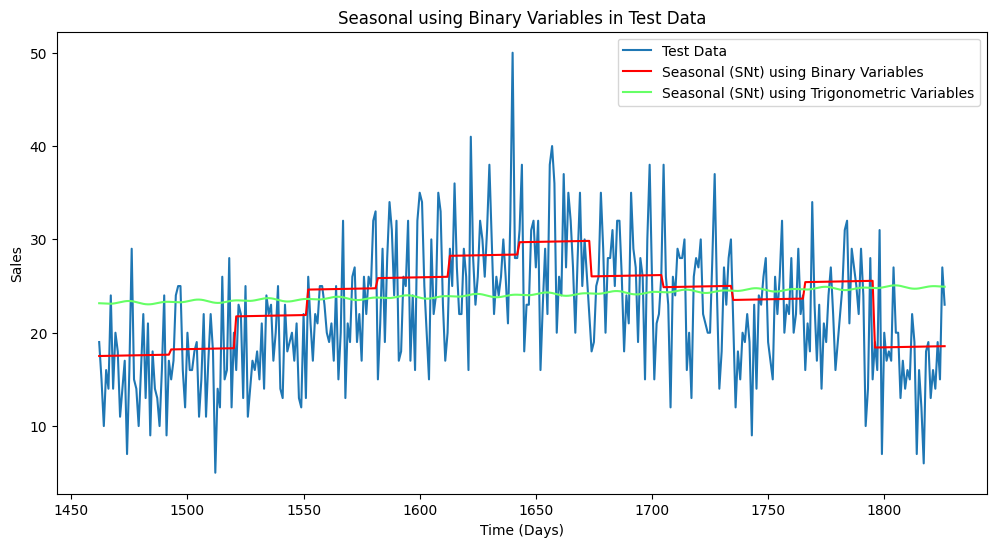

Mean Squared Error (Binary Variables): 34.65782849679375
Mean Squared Error (Trigonometric): 50.82760999623026


In [ ]:
from sklearn.metrics import mean_squared_error
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf

#훈련된 모델의 테스트 데이터에 대한 평가를 수행하고, 두 모델(이진 변수 모델과 삼각 함수 모델)의 예측 성능을 비교하여 시각화 및 오차(MSE)를 계산하는 과정

df_test_bi = y_to_test.to_frame()
df_test_bi['t'] = np.arange(1462, len(df_test_bi) + 1462)
df_test_bi['constant']=1
df_test_bi['month'] = df_test_bi.index.month
# Create month dummy variables
df_test_bi = pd.get_dummies(df_test_bi, columns=['month'], drop_first=False)

# Remove the December column
df_test_bi.drop(columns=['month_12'], inplace=True)

# Ensure that each month column only has values for the respective month
month_columns = [col for col in df_test_bi.columns if col.startswith('month_')]
for col in month_columns:
    month = int(col.split('_')[1])
    df_test_bi[col] = (df_test_bi.index.month == month).astype(int)

X_test_seasonal_binary = df_test_bi.drop(columns=['sales'])
y_test_seasonal_binary = df_test_bi['sales']


df_test_tri = y_to_test.to_frame()
df_test_tri['t'] = np.arange(1462, len(df_test_tri) + 1462)
df_test_tri['constant']=1
L = 30
df_test_tri['(sin2pi)/L'] = np.sin(2 * np.pi * df_test_tri['t'] / L)
df_test_tri['(cos2pi)/L'] = np.cos(2 * np.pi * df_test_tri['t'] / L)
df_test_tri['(sin4pi)/L'] = np.sin(4 * np.pi * df_test_tri['t'] / L)
df_test_tri['(cos4pi)/L'] = np.cos(4 * np.pi * df_test_tri['t'] / L)


X_test_seasonal_tri = df_test_tri.drop(columns=['sales'])
y_test_seasonal_tri = df_test_tri['sales']


seasonal_binary_test = seasonal_model_binary.predict(X_test_seasonal_binary)
seasonal_tri_test = seasonal_model_tri.predict(X_test_seasonal_tri)


# Visualization
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1462, len(df_test_tri) + 1462), y_to_test.values, label='Test Data')
#plt.plot(range(len(y_to_train)), TRt_train, label='Training Data', color='red')
plt.plot(np.arange(1462, len(df_test_tri) + 1462), seasonal_binary_test, label='Seasonal (SNt) using Binary Variables', color='red')
plt.plot(np.arange(1462, len(df_test_tri) + 1462), seasonal_tri_test, label='Seasonal (SNt) using Trigonometric Variables', color=(0.4, 1.0, 0.4))
plt.title('Seasonal using Binary Variables in Test Data')
plt.xlabel('Time (Days)')
plt.ylabel('Sales')
plt.legend()
plt.show()


mse_binary = mean_squared_error(y_test_seasonal_binary, seasonal_binary_test)
mse_trig = mean_squared_error(y_test_seasonal_tri, seasonal_tri_test)

print(f'Mean Squared Error (Binary Variables): {mse_binary}')
print(f'Mean Squared Error (Trigonometric): {mse_trig}')




# 4-2 Modeling Growth Curve Models

### Step 1: Prepare the data (Number of branches of Western Steakhouses for 15 years)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Example data from the document
data = {
    "Year": np.arange(1,16),
    "Branches": [11, 14, 16, 22, 28, 36, 46, 67, 82, 99, 119, 156, 257, 284, 403]
}

# Convert to DataFrame
df = pd.DataFrame(data)
print(df)

    Year  Branches
0      1        11
1      2        14
2      3        16
3      4        22
4      5        28
5      6        36
6      7        46
7      8        67
8      9        82
9     10        99
10    11       119
11    12       156
12    13       257
13    14       284
14    15       403


### Step 2: Transform the data using the logarithm

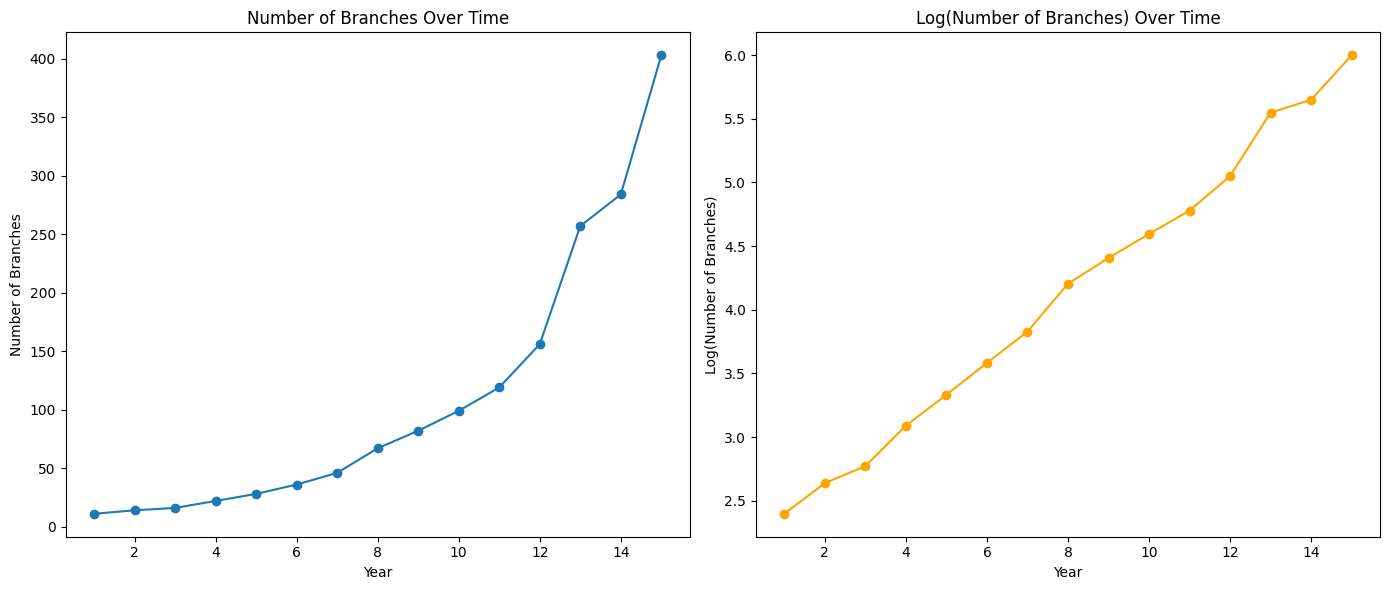

In [ ]:
# Apply logarithmic transformation
df['Log_Branches'] = np.log(df['Branches'])

# Plot the original data
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(df['Year'], df['Branches'], marker='o')
plt.title('Number of Branches Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Branches')

# Plot the logarithmically transformed data
plt.subplot(1, 2, 2)
plt.plot(df['Year'], df['Log_Branches'], marker='o', color='orange')
plt.title('Log(Number of Branches) Over Time')
plt.xlabel('Year')
plt.ylabel('Log(Number of Branches)')

plt.tight_layout()
plt.show()

### 3-1 Fit a linear regression model to raw data


In [ ]:
# Define the predictor (Year) and response (Log_Branches)
X_lin = df['Year']
y_lin = df['Branches']

# Add a constant to the predictor
X_lin = sm.add_constant(X_lin)

# Fit the linear regression model
model_lin = sm.OLS(y_lin, X_lin).fit()

# Print the summary of the model
print(model_lin.summary())

                            OLS Regression Results                            
Dep. Variable:               Branches   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     47.49
Date:                Thu, 26 Sep 2024   Prob (F-statistic):           1.10e-05
Time:                        00:22:31   Log-Likelihood:                -80.781
No. Observations:                  15   AIC:                             165.6
Df Residuals:                      13   BIC:                             167.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -77.5238     30.817     -2.516      0.0

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Step 3-2: Fit a linear regression model to the transformed data

In [ ]:
# Define the predictor (Year) and response (Log_Branches)
X_log = df['Year']
y_log = df['Log_Branches']

# Add a constant to the predictor
X_log = sm.add_constant(X_log)

# Fit the linear regression model
model_log = sm.OLS(y_log, X_log).fit()

# Print the summary of the model
print(model_log.summary())

                            OLS Regression Results                            
Dep. Variable:           Log_Branches   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     3240.
Date:                Thu, 26 Sep 2024   Prob (F-statistic):           5.60e-17
Time:                        00:22:31   Log-Likelihood:                 18.540
No. Observations:                  15   AIC:                            -33.08
Df Residuals:                      13   BIC:                            -31.66
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0701      0.041     50.451      0.0

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  res = hypotest_fun_out(*samples, **kwds)


### Step 4: Evaluate the model

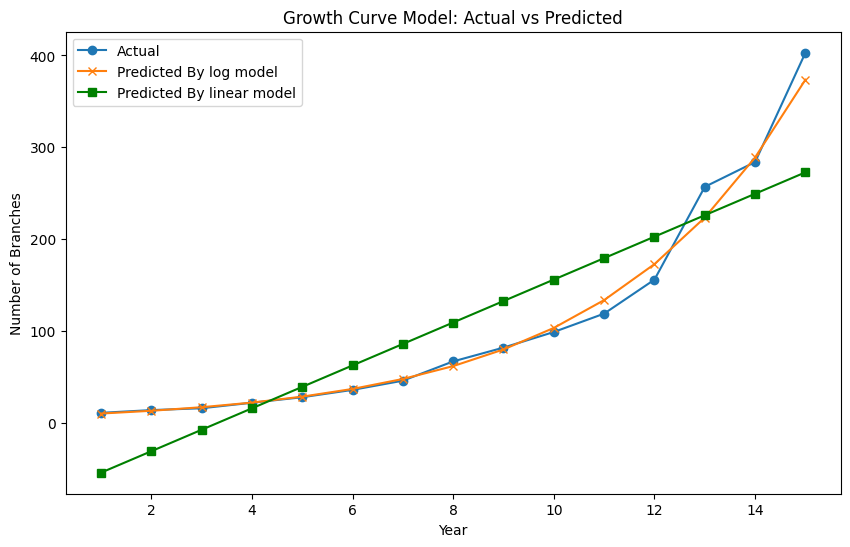

In [ ]:
# Predicted values
df['Predicted_Log_Branches'] = model_log.predict(X_log)
df['Predicted_Branches'] = np.exp(df['Predicted_Log_Branches'])
df['Predicted_Branches_By_Linear'] = model_lin.predict(X_lin)

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['Branches'], label='Actual', marker='o')
plt.plot(df['Year'], df['Predicted_Branches'], label='Predicted By log model', marker='x')
plt.plot(df['Year'], df['Predicted_Branches_By_Linear'], label='Predicted By linear model', marker='s', color='green')
plt.xlabel('Year')
plt.ylabel('Number of Branches')
plt.title('Growth Curve Model: Actual vs Predicted')
plt.legend()
plt.show()

### Step 5 : Error Measure

In [ ]:
df['Error_Log_Model'] = df['Branches'] - df['Predicted_Branches']
df['Error_Linear_Model'] = df['Branches'] - df['Predicted_Branches_By_Linear']

# Mean Squared Error (MSE)
mse_log_model = np.mean(df['Error_Log_Model'] ** 2)
mse_linear_model = np.mean(df['Error_Linear_Model'] ** 2)

# Mean Absolute Error (MAE)
mae_log_model = np.mean(np.abs(df['Error_Log_Model']))
mae_linear_model = np.mean(np.abs(df['Error_Linear_Model']))


print("MSE Error for log_model:"+str(mse_log_model))
print("MSE Error for linear_model:"+str(mse_linear_model))
print("MAE Error for log_model:"+str(mae_log_model))
print("MAE Error for linear_model:"+str(mae_linear_model))


MSE Error for log_model:171.0552832209165
MSE Error for linear_model:2787.7079365079367
MAE Error for log_model:7.818919269243196
MAE Error for linear_model:44.679365079365084
